In [1]:
from pandas import *
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
from IPython.display import HTML, display
from IPython.display import Image

In [2]:
from datetime import datetime
start = datetime.now()

## MODEL 1 - Word Frequency Algorithm and Sentence scoring using Term Frequency Algorithm 

In [3]:
tp = read_csv('articles1.csv', iterator=True, chunksize=20)
df = concat(tp, ignore_index=True)
articles = df['content'].reset_index(drop=True)


In [4]:
def create_freq_table(article):
    stopWords = set(stopwords.words("english"))
    words = word_tokenize(article)
    ps = PorterStemmer()
    wordfreqTable = dict()
    for word in words:
        word = ps.stem(word)
        if word in stopWords:
            continue
        if word in wordfreqTable:
            wordfreqTable[word] += 1
        else:
            wordfreqTable[word] = 1

    return wordfreqTable

In [5]:
def score_sentences_tf(sentences, wordfreqTable):
    sentenceScore = dict()

    for sentence in sentences:
        word_count_in_sentence = (len(word_tokenize(sentence)))
        for wordFreq in wordfreqTable:
            if wordFreq in sentence.lower():
                if sentence[:15] in sentenceScore:
                    sentenceScore[sentence[:15]] += wordfreqTable[wordFreq]
                else:
                    sentenceScore[sentence[:15]] = wordfreqTable[wordFreq]

        sentenceScore[sentence[:15]] = sentenceScore[sentence[:15]] / word_count_in_sentence
    return sentenceScore   

In [6]:
def average_score_of_art(sentenceScore):
    sumScores = 0
    for entry in sentenceScore:
        sumScores += sentenceScore[entry]
    average = int(sumScores / len(sentenceScore))

    return average

In [7]:
def generate_summary(sentences, sentenceScore, threshold):
    sentence_count = 0
    summary = ''

    for sentence in sentences:
        if sentence[:15] in sentenceScore and sentenceScore[sentence[:15]] > (threshold):
            summary += "" + sentence
            sentence_count += 1

    return summary

In [8]:
for i in range(0,10):
    freqs = create_freq_table(articles[i])
    sents = sent_tokenize(articles[i])
    sentence_scores = score_sentences_tf(sents,freqs)
    threshold = average_score_of_art(sentence_scores)
    summary = generate_summary(sents, sentence_scores, 1.2 * threshold)
    print("Summarized Article from Model I :",i, summary)
    print(" ")

Summarized Article from Model I : 0 WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win.In another twist, Donald J. Trump’s administration, worried about preserving executive branch prerogatives, could choose to fight its Republican allies in the House on some central questions in the dispute.“Upon taking office, the Trump administration will evaluate this case and all related aspects of the Affordable Care Act.House Republicans contend that Congress never appropriated the money for the subsidies, as required by the Constitution.
 
Summarized Article from Model I : 1 By September, four of every five shootings in the precinct this year were unsolved.And across the Bronx, investigative resources are squeezed.So though people see a lot, they rarely testify.This is the paradox of policing in the 40th Precinct.“Here, we have nothing,” she said.When it comes to “  families,” she said, the aut

In [9]:
end = datetime.now()
time_taken = end - start
print('Total Time Taken using model I: ',time_taken) 

Total Time Taken using model I:  0:00:21.394226


## MODEL 2 - Cosine Similarity Algorithm and Sentence score using TextRank Algorithm

In [10]:
from datetime import datetime
start = datetime.now()

In [11]:
def sents_similarity(s1, s2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    s1 = [w.lower() for w in s1]
    s2 = [w.lower() for w in s2]
 
    all_words = list(set(s1 + s2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in s1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in s2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
    
    return 1 - cosine_distance(vector1, vector2)

In [12]:
def similarity_matrix(sents, stop_words):
    # Create an empty similarity matrix
    matrix = np.zeros((len(sents), len(sents)))
 
    for index1 in range(len(sents)):
        for index2 in range(len(sents)):
            if index1 == index2: #ignore if both are same sentences
                continue 
            matrix[index1][index2] = sents_similarity(sents[index1], sents[index2], stop_words)

    return matrix


In [13]:
def generate_model2_summary(sents, top_s=5):
    stop_words = stopwords.words('english')
    summarize_text = []
    sent_similarity_matrix = similarity_matrix(sents, stop_words)

    # Rank sentences in similarity martix
    sent_similarity_graph = nx.from_numpy_array(sent_similarity_matrix)
    scores = nx.pagerank(sent_similarity_graph)

    # Sort the rank and pick top sentences
    ranked_sent = sorted(((scores[i],s) for i,s in enumerate(sents)), reverse=True)       

    for i in range(top_s):
        summarize_text.append("".join(ranked_sent[i][1]))

    #  Finally, output the summarize text
    print("Summarize Text: \n", ". ".join(summarize_text))

     

In [14]:
for i in range(0,10):
    sents = sent_tokenize(articles[i])
    generate_model2_summary(sents, 4)

Summarize Text: 
 Just as important to House Republicans, Judge Collyer found that Congress had the standing to sue the White House on this issue  —   a ruling that many legal experts said was flawed  —   and they want that precedent to be set to restore congressional leverage over the executive branch.. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been demanding an end to the law for years.. ” The suspension of the case, House lawyers said, will “provide the   and his future administration time to consider whether to continue prosecuting or to otherwise resolve this appeal.. ” In a potentially   decision in 2015, Judge Rosemary M. Collyer ruled that House Republicans had the standing to sue the executive branch over a spending dispute and that the Obama administration had been distributing the health insurance subsidies, in violatio

In [15]:
end = datetime.now()
time_taken = end - start
print('Total Time Taken using model II: ',time_taken) 

Total Time Taken using model II:  0:01:28.770860


<h1><center>Extractive Summarization of News articles</center></h1>

### Introduction:

>Automatic text summarization is one of the most intersting topics in NLP which has an impact in our everyday lives. The motivation of this project is to summarize all the important information from an article to help us decide if the whole article is worth reading. Now instead of just skimming a huge article we can read the automated summary with the most important features included. Text summarization in general is categorised into Abstractvie summarization and Extractive summarization. We have choosen to implement two extractive summarization algorithms which are based on the techniques of sentence extraction. We attempt to identify the set of sentences that are most important for the understanding of a given article. There are many techniques available for Extractive summarization, so to keep it simple we are using unsupervised learning approachs. In this project we are creating article summaries using two different unsupervised algorithms.The intention of using two different algorithm is to evaluate the model's summary and identify which algorithm provides a better summary compared to the other and in what ways.
1. Word Frequency algorithm - Sentence score based on Term frequency algorithm. 
2. Cosine similarity algorithm - Sentence score based on TextRank algorithm.


### DATA: 

>Articles1.csv is the dataset we have picked from Kaggle "All the News" for summarizing articles in the content field of the dataset. This Dataset has a total of 53291 articles from which we have tested our code for 100 to 2000 articles. However the final model generates summaries for up to 10 articles. The articles in the dataset are of varying lengths which made the process of summarizing every article a bit tough. Since both our models are based on extracting sentences based on the scores, the uneven sized article made it difficult to keep constant threshold. For evaluation purposes we have split the data into even sized articles (of a descent length...not too short) and generated summaries for them using both our models. Evaluation is explained in the end of the report. 

## Model 1- WordFrequency Algorithm - Sentence Score using Term Frequency : 
>A mathematical approach to extract sentences based on their scores. Below are the steps we take:

1. Read the dataset csv file for content row which has all the articles. 

2. Create a frequency table for the list of words in the article- ignoring stop words.

3. Sentence tokenize each article and store as a list of sentences 

4. Scoring the sentences based on Term Frequency Method. In brief, scoring a sentence by its words, adding together the frequency of every non-stop word in a sentence.

5. Find the threshold, which will be used later to determine which sentences will be included in our summary. In this stage we define an article's average sentence score as it's threshold. 

6. Generate summary by selecting the top ranked sentences from our sentence score dictionary. If the sentence scores are greater than the threshold or average score (adjusted with a multiplier), then return the sentences and stack them up together as a single summary.

## How it works?
>We have created 4 functions to extract a summary for N number of articles in our dataset (Articles.csv). Below are detailed explanations of how each function in our model works. We use an example article taken from the dataset(article 5). This shows step by step how the final summary is being generated. 

###### Original Article: 
__LONDON _ Queen Elizabeth II, who has been battling a cold for more than a week, missed a New Years Day church service at her country estate in Sandringham, Buckingham Palace said on Sunday. A week earlier, the queen, who is 90, missed a Christmas Day church service, for the first time since 1988, because of the illness."The Queen does not yet feel ready to attend church as she is still recuperating from a heavy cold” the palace said in a statement. The queen's husband, Prince Philip, who had also been ill, was well enough to attend both services, in the church at Sandringham, which is in Norfolk, on the east coast of England. The queen, who ascended to the throne in 1952, became the worlda's   monarch following the death of King Bhumibol Adulyadej of Thailand in October. She is also Britaina's   monarch, having last year surpassed Queen Victoria's  reign. Her mother lived until the age of 101.__

###### __create_freq_table:__ 
>This function creates a frequency table dictionary that holds the frequency of all the words in an article. The words are normalized using word_tokenize, and porter stemmer algorithm to count the frequency of stem words. Stop words are not included in the frequency table. wordfreqTable dictonary looks like below,

{'london': 1, '—': 1, 'queen': 6, 'elizabeth': 1, 'II': 1, ',': 18, 'ha': 1, 'battl': 1, 'cold': 2, 'week': 2, 'miss': 2, 'new': 1, 'year': 2, '’': 5, 'day': 2, 'church': 4, 'servic': 3, 'countri': 1, 'estat': 1, 'sandringham': 2, 'buckingham': 1, 'palac': 2, 'said': 2, 'sunday': 1, '.': 7, 'A': 1, 'earlier': 1, '90': 1, 'christma': 1, 'first': 1, 'time': 1, 'sinc': 1, '1988': 1, 'becaus': 1, 'ill': 2, '“': 1, 'doe': 1, 'yet': 1, 'feel': 1, 'readi': 1, 'attend': 2, 'still': 1, 'recuper': 1, 'heavi': 1, '”': 1, 'statement': 1, 'husband': 1, 'princ': 1, 'philip': 1, 'also': 2, 'wa': 1, 'well': 1, 'enough': 1, 'norfolk': 1, 'east': 1, 'coast': 1, 'england': 1, 'ascend': 1, 'throne': 1, '1952': 1, 'becam': 1, 'world': 1, 'monarch': 2, 'follow': 1, 'death': 1, 'king': 1, 'bhumibol': 1, 'adulyadej': 1, 'thailand': 1, 'octob': 1, 'britain': 1, 'last': 1, 'surpass': 1, 'victoria': 1, 'reign': 1, 'mother': 1, 'live': 1, 'age': 1, '101': 1}

##### __score_sentences_tf:__ 

>Scoring the sentences based on term frequency. In our model we are scoring a sentence by its words, adding the frequency of every non-stop words in a sentence. For each sentence in an article word count of the sentence is stored in a variable. For each word in the wordfreqTable dictionary, if the word is present in the sentence add the freq count of word into sentenceScore dictionary.A potential issue with our scoring algorithm is that the longer sentences will have advantage over shorter sentences. To resolve this, we are dividing every sentence score by the number of words in the sentence, to make scoring fair. We have used sentence [:15] which is the first 15 characters of any sentence, this is to save memory overhead while making dictionary easier to read. Below is the dictionary result with each sentence showing up to 15 characters as it's key.

{'LONDON — Que': 1.725, 'A week earlier,': 1.8, '“The Queen does': 1.8275862068965518, 'The queen’s hus': 1.5121951219512195, 'The queen, who ': 1.7586206896551724, 'She is also Bri': 2.6666666666666665, 'Her mother live': 1.2222222222222223}

##### __average_score_of_art:__
>This function is passed in our sentence score dictionary and returns the average sentence score of an article. We are considering average score as our threshold for generating summary. The average score of the sentence is derived as int(sumScores / len(sentenceValue)). Here the sumScores is sum of all sentence scores from sentenceValue dictionary and the denominator is the number of sentences in the article. Average score calculation for articles 5 from the dataset is as below. 

1.725 + 1.8 + 1.8275862068965518 + 1.5121951219512195 + 1.7586206896551724 + 2.6666666666666665 +1.2222222222222223 / 7 

Average score = int(1.7874701296274047) = 1 
 
##### __generate_summary:__

>Finally, the function that generates the summary based on all the math we have done in our previous functions. Basic idea is to select sentences from the article to be included in our summary, if the sentence score is greater than the average score. Generate summary function takes three inputs (sentences, sentenceScore and threshold). The first argument sentences holds a sentence tokenized article. The next argument sentenceScore is our dictionary of sentence scores, created using the score_sentences_tf fuction. For the "Threshold" we have used 1.2x*average score in our model, however 1.2 is not a constant value that is suitable for all the articles due to their varying lengths. In this example with a threshold of 1.2*average score the whole article is itself a summary due to the length of the article. For explanatory purpose different threshold results are shown as below, 

1.5*average_score          = 1 *1.5        = 1.5

<u>sentences with sentence score greater than 1.5 are:</u>

{'LONDON — Que': 1.725, 'A week earlier,': 1.8, '“The Queen does': 1.8275862068965518, 'The queen’s hus': 1.5121951219512195, 'The queen, who ': 1.7586206896551724, 'She is also Bri': 2.6666666666666665}

1.6* average_score         = 1 *1.6        = 1.6

<u>sentences with sentence score greater than 1.6 are:</u>

{'LONDON — Que': 1.725, 'A week earlier,': 1.8, '“The Queen does': 1.8275862068965518, 'The queen, who ': 1.7586206896551724, 'She is also Bri': 2.6666666666666665}

1.8* average_score         = 1 *1.8         = 1.8

<u>sentences with sentence score greater than 1.8 are:</u>

{'“The Queen does': 1.8275862068965518, 'She is also Bri': 2.6666666666666665}

<u>__Output summary for the above calculations:__</u>

<b>Summarize Text for average score of 1.5:</b> 

  LONDON  —   Queen Elizabeth II, who has been battling a cold for more than a week, missed a New Year’s Day church service at her country estate in Sandringham, Buckingham Palace said on Sunday. A week earlier, the queen, who is 90, missed a Christmas Day church service, for the first time since 1988, because of the illness. “The Queen does not yet feel ready to attend church as she is still recuperating from a heavy cold,” the palace said in a statement. The queen’s husband, Prince Philip, who had also been ill, was well enough to attend both services, in the church at Sandringham, which is in Norfolk, on the east coast of England. The queen, who ascended to the throne in 1952, became the world’s   monarch following the death of King Bhumibol Adulyadej of Thailand in October. She is also Britain’s   monarch, having last year surpassed Queen Victoria’s   reign.

<b>Summarize Text for average score of 1.6:</b>

LONDON  —   Queen Elizabeth II, who has been battling a cold for more than a week, missed a New Year’s Day church service at her country estate in Sandringham, Buckingham Palace said on Sunday. A week earlier, the queen, who is 90, missed a Christmas Day church service, for the first time since 1988, because of the illness. “The Queen does not yet feel ready to attend church as she is still recuperating from a heavy cold,” the palace said in a statement. The queen, who ascended to the throne in 1952, became the world’s   monarch following the death of King Bhumibol Adulyadej of Thailand in October. She is also Britain’s   monarch, having last year surpassed Queen Victoria’s   reign.

<b>Summarize Text for average score of 1.8:</b> 

  “The Queen does not yet feel ready to attend church as she is still recuperating from a heavy cold,” the palace said in a statement. She is also Britain’s   monarch, having last year surpassed Queen Victoria’s   reign.

## __What did not workout in this model:__

>The threshold argument is used to control if the sentence is included in the summary. If the sentence's score is above the threshold argument (which is multiplied by a variable 1.2 or any value of our choice) it is included in the summary. The higher the value you multiply the threshold by the smaller your summary will be since threshold is higher. Feel like a multiplier of 1.3 - 1.7 returns a good length summary, depending on the length of original article. If article is short like article[5] it is hard to return a summary that doesn’t include all or most of the 6 sentence article (summary generated with threshold *1.5 returned the whole article). Also some summaries read better when they are shorter, while others make more sense given a few extra sentences. We don’t want it to be too short but also don’t want it to be too long. Feel like 3-6 sentences is a good length range on average. But again due to the varying sized articles we found it hard to find a universal threshold that was ideal for all cases. Because of that and other issues dealing with evaluation, we decided to only run our evaluation on evenly lengthed articles that were of a descent size (not too short like article[5])

<b>Examples:</b>

article[1] 1.5*threshold = By September, four of every five shootings in the precinct this year were unsolved. And across the Bronx, investigative resources are squeezed. So though people see a lot, they rarely testify. “Here, we have nothing,” she said. That’s how I feel. Both are unsolved. He chose the police. Around 6:30 each morning, Sgt. “Not because they wanted to, but because they had to. “It was like a heaviness. Last year, the precinct drew the number of civilian complaints for officer misconduct in the city, and the most lawsuits stemming from police actions. “That perception really sticks,” he said. Last year, the 40th was the for violent crime, with 65 cases per detective. “The outer boroughs are, like, forgotten. By October, Mr. Fernandez was increasingly afraid — and fed up. The menacing worsened. “We went to all proper channels for help,” the note said. He even hired a drug customer to sweep the hallway, Mr.Fernandez said. But two weeks later, the dealing and the harassment resumed. By May, he had moved his family away.

article[1] - 1.9*threshold = And across the Bronx, investigative resources are squeezed. “Here, we have nothing,” she said. Both are unsolved. Around 6:30 each morning, Sgt. “That perception really sticks,” he said. “The outer boroughs are, like, forgotten. The menacing worsened. By May, he had moved his family away.

## __MODEL 2 - Cosine Similarity Algorithm - Sentence Score using TextRank:__ 
>Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Representing our sentences as a bunch of vectors, we can find the similarity among sentences, by measuring the cosine of the angle between the vectors. Angle will be 0 if sentences are similar.

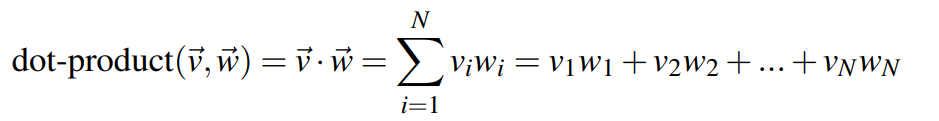

1. Input Dataset and Sentence tokenize using nltk sent_tokenize.

2. Remove stop words. 

3. Find the sentence similairty using cosine simialrity algorithm by representing sentences as bunch of vectors and build a similarity matrix

4. Convert similarity matrix into a graph, with sentences as vertices and similarity scores as edges for sentence rank calcualtion using inbuilt function PageRank. 

5. Pick top N sentences for summary and summarize text. 

## __How it works?__ 

>We are taking the same example article used for explaining model 1 to show how different the summaries are for different algorithms. 

###### __Original Article:__ 
>LONDON _ Queen Elizabeth II, who has been battling a cold for more than a week, missed a New Years Day church service at her country estate in Sandringham, Buckingham Palace said on Sunday. A week earlier, the queen, who is 90, missed a Christmas Day church service, for the first time since 1988, because of the illness."The Queen does not yet feel ready to attend church as she is still recuperating from a heavy cold” the palace said in a statement. The queen's husband, Prince Philip, who had also been ill, was well enough to attend both services, in the church at Sandringham, which is in Norfolk, on the east coast of England. The queen, who ascended to the throne in 1952, became the worlda's   monarch following the death of King Bhumibol Adulyadej of Thailand in October. She is also Britaina's   monarch, having last year surpassed Queen Victoria's  reign. Her mother lived until the age of 101.

<b>__sents_similarity:__</b>

>Function to find the similarity between two sentences at a time, creating a similarity matrix. For explanatory purpose we take first 2 sentences of the articles summary.  

S1 = “LONDON  —   Queen Elizabeth II, who has been battling a cold for more than a week, missed a New Year’s Day church service at her country estate in Sandringham, Buckingham Palace said on Sunday.”

S2 = "The queen, who ascended to the throne in 1952, became the world’s   monarch following the death of King Bhumibol Adulyadej of Thailand in October."

>We want to know how similar the sentences are in an article purely in terms of word counts (and ignoring word orders). We begin by making a list of lowercased unique words from s1 and s2 and count the number of times each of these words appears in each sentence. 

<b>all_words</b> ['ii', 'more', 'service', 'has', 'her', 'adulyadej', 'for', 'to', '’', 'church', 'thailand', 'queen', 'death', 'week', 'country', 'a', 'on', 'following', 'cold', 'king', 'bhumibol', 's', '1952', 'october', 'london', 'than', 'year', 'estate', 'elizabeth', 'missed', 'world', 'in', 'of', 'throne', 'at', '.', 'the', 'said', ',', 'new', 'became', 'buckingham', 'sandringham', 'who', 'been', 'palace', 'ascended', 'battling', 'monarch', 'sunday', 'day']


>We are not interested in the words themselves though. We are interested only in two vertical vectors of counts. For instance, there are two instances of ‘queen’ in each text. We are going to decide how close these two texts are to each other by calculating one function of those two vectors, namely the cosine of the angle between them.

__The vector counts looks like this for each sentence:__

<b>vector1</b>
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 3, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1]
 
<b>vector2</b>
 [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
 
>The inbuilt function _cosine_distance_ from nltk.cluster.util is utilised to derive the cosine similarity between two sentence. It returns 1 minus the cosine of the angle between vectors v and u. This is equal to 1 - (u.v / |u||v|). The cosine similarity of the two sentences is about 0.3451342449813166. 

<b>__similarity_matrix:__</b> 

>Finds the similarity between the sentences and stores the cosine similarity scores in a matrix. This function takes in a sentence tokenized article stored as a list of strings, along with a list of stopwords. Lets first define a zero matrix of dimensions (n * n). Here, n is the number of sentences. We will initialize this matrix with cosine similarity scores of the sentences by calling the function sents_similarity between a pair of sentences and returning their similarity scores. Scores are calculated based on the cosine similarity algorithm as explained in the previous function. A similarity matrix is created for the sentences in articles[5] from dataset as shown below. If two sentences are same in the article, we ignore, when scoring and leave as 0. 



[[0.         0.92779537 0.960855   0.96838165 0.95208281 0.94479297
  0.86640588]
 [0.92779537 0.         0.93892901 0.92438319 0.88850726 0.9174406
  0.8791457 ]
 [0.960855   0.93892901 0.         0.94246758 0.93877417 0.90397923
  0.90485679]
 [0.96838165 0.92438319 0.94246758 0.         0.96437858 0.92056046
  0.88076258]
 [0.95208281 0.88850726 0.93877417 0.96437858 0.         0.85200719
  0.92019397]
 [0.94479297 0.9174406  0.90397923 0.92056046 0.85200719 0.
  0.79665194]
 [0.86640588 0.8791457  0.90485679 0.88076258 0.92019397 0.79665194
  0.]]
  

<b>__generate_model2_summary__:</b> 

>This function puts everything together. It is passed in a sentence tokenized article, and returns a generated summary, by calling the above two functions.The matrix returned from similarity_matrix function is converted into a graph.The node of this graph will represent the sentences and the edges will represent the similarity scores between the sentences. PageRank algorithm is applied on this graph for ranking the sentences. Finally, the sorted top n ranked sentences output as our summary. In our code we are resulting top 4 sentences as a summary (n being a 2nd parameter passed in controling the length of the summary). 



>Page rank Algorithm takes the sent_similarity graph results as an input and find the scores. In our code we have used the inbuilt PageRank function from networkx package. When we call the inbuilt function on the similarity graph, it will return the scores of all the sentences with the most important sentence having the highest scores. Since we are not experimenting on how the calculation works to score the sentences based on the similarity matrix in our code, here is a basic understanding on PageRank algorithm. 

>PageRank algorithm is primarily used for ranking web pages in online search results to compute a score based on the probability of a user visiting the page. To capture probability of users navigating from one page to another a square matrix m is created with n rows and n columns, where n is the number of web pages. Each node in the matrix denotes the probability of users transitioning from one web page to another. Finally, the values in the matrix will be updated in an iterative fashion to arrive at a web page ranking. 

>Note we are using TextRank algorithm to score our sentences. Pagerank is explained above to understand the concept. The difference between PageRank and TextRank is that instead of webpages we use sentences. Similarity between two sentences is used as an equivalent to web page probability and the sqaure matrix is stored with similarity scores like the Matrix M used for pagerank.  


<u><b>Sentence scores using PageRank function looks like below.</b></u>

{0: 0.1459450580298527, 1: 0.14268848582308816, 2: 0.1452590816008353, 3: 0.1455070745112012, 4: 0.1435837363327568, 5: 0.139493179182673, 6: 0.13752338451959262}

>These are the resulting sentence scores of our example article. The model 2 summary would include the top 4 sentences (if 4 was used as 2nd param in the generate_model2_summary function call):

<u><b>Ranked Sentences.<b></u>
    
[(0.1459450580298527, 'LONDON  —   Queen Elizabeth II, who has been battling a cold for more than a week, missed a New Year’s Day church service at her country estate in Sandringham, Buckingham Palace said on Sunday.'), (0.1455070745112012, 'The queen’s husband, Prince Philip, who had also been ill, was well enough to attend both services, in the church at Sandringham, which is in Norfolk, on the east coast of England.'), (0.1452590816008353, '“The Queen does not yet feel ready to attend church as she is still recuperating from a heavy cold,” the palace said in a statement.'), (0.1435837363327568, 'The queen, who ascended to the throne in 1952, became the world’s   monarch following the death of King Bhumibol Adulyadej of Thailand in October.'), (0.14268848582308816, 'A week earlier, the queen, who is 90, missed a Christmas Day church service, for the first time since 1988, because of the illness.'), (0.139493179182673, 'She is also Britain’s   monarch, having last year surpassed Queen Victoria’s   reign.'), (0.13752338451959262, 'Her mother lived until the age of 101.')]

## Evaluation of Summaries

>Below is a chart with the results of our human evaluation. To evaluate our models we first had to hand-write summaries for each of four evenly lengthed articles. We saved these even sufficiently lengthed articles into a list named large_arts. We evaluted on large_arts[0] large_arts[1], large_arts[2], and large_arts[3]. The setup of the evaluation included the article headline followed by three summaries (one generated by our first model, one generated by our second model and the third being our hand written summary). The handwritten summary was mostly extractive (using sentences from the original article) with a few minor exceptions and alterations to try to keep the evaluation somewhat fair (since both of our models are extractive). We asked human judges based on the headline to choose the summary that makes the most sense, and seems like it would have most likely been written by hand as oppose to generated by a computer. We ran evaluation set up in this manner on 8 individuals; Below are the results. M1 means they choose our first model (using word frequencies) as being the best of the three summary options, while M2 means they choose the second model (which uses cosine distance and textrank) as the best. HW means that they choose the hand written summary as being the "best" of the three options.


|article index  |Subj 1  |Subj 2  |Subj 3  |Subj 4  |Subj 5  |Subj 6  |Subj 7  |Subj 8  |
|---------------|--------|--------|--------|--------|--------|--------|--------|--------|
|large_arts[0]  |M2      |HW      |HW      |M1      |HW      |HW      |HW      |HW      |
|large_arts[1]  |HW      |HW      |HW      |HW      |M2      |HW      |M1      |M2      |       
|large_arts[2]  |HW      |HW      |HW      |HW      |HW      |HW      |HW      |HW      |       
|large_arts[3]  |HW      |HW      |HW      |M2      |HW      |HW      |HW      |HW      |

> As you can see neither model faired well against our handwritten summaries. Seems like neither of these extractive models were that convincing. 
******************************************************************************************************************
***A few notable observations***:
1. For large_arts[2] none of our judges could be fooled into thinking either of our models was a human.
2. Three of our subjects guessed the hand written summary for each of the four articles.
3. Overall model 2 seemed to fool people more than model 1 but it is hard to tell since most guesses were for hand written summary.

> Because of the high prevalance of human judges choosing hand written summaries for most of their guesses, we decided to further evaluate using the same setup with the same article's headlines followed by the same three summaries: M1, M2 and HW. We asked our new set of judges to not only guess which headline's summary they thought was the best (most likely hand written and easiest to read and follow) we also asked them to choose which was the worst (hardest to understand and follow, and most likely not hand written), basically ranking them from best to worst. This way even if they choose HW as the being the best as most judges did, we can still easily compare our two models to one another directly. The chart below shows out of Model 1 (M1) and Model 2 (M2), which summary was choosen over the other as being better (easier to follow and understand and more likely hand written summary).

|article index  |Subj 1  |Subj 2  |Subj 3  |Subj 4  |
|---------------|--------|--------|--------|--------|
|large_arts[0]  |  M1    |  M1    |  M2    |  M2    |
|large_arts[1]  |  M1    |  M1    |  M2    |  M2    |        
|large_arts[2]  |  M1    |  M1    |  M2    |  M2    |        
|large_arts[3]  |  M2    |  M2    |  M2    |  M2    |   

>Noteable Observations:
1. For large_arts[3] all of our subjects thought that model 2 produced a better summary.
2. Data on the other three articles was mostly split.
3. 2 of the 4 judges choose model 2 for all 4 articles.
4. 2 of the 4 subjects choose model 1 for 3 of the 3 articles (again, no one choose model 1 for large_arts[3]).

>__Observations:__
> Neither model seems to outperform the other by a significant amount. Seems to depend on the article and the judge. Overall neither model performed that well, compared to a human. Most of the issues seems to be due to the extractive nature of the algorithms. For instance large_arts[0] model 1 summary begins like this; __By midmorning, Mr. Trump had weighed in, questioning the members’ priorities on Twitter. Minutes later, members emerged to say the changes had been scrapped.__ What _changes_ are they refering to and what _members_ of what? This isn't clear to the reader. Even though these sentences scored high, stacked together without syntax they don't make sense.The handwritten summaries we used for evaluation purposes can be found in the attached csv file (which also contains summaries for 100 articles from our original uneven article list generated by both models). The computer generated summaries used for our evaluation will output in the below code. We used a threshold multiplier of 1.3, and model 2 summary was 4 sentences long.

## Code for Evaluating the summaries 

In [16]:
large_arts = [x for x in articles if len(x) >8000 and len(x) <8010 ]

In [17]:
## for loop to iterate through large_articles - Model 1 - Evaluvation 
for i in range(0,4):
    freqs = create_freq_table(large_arts[i])
    sents = sent_tokenize(large_arts[i])
    sentence_scores = score_sentences_tf(sents,freqs)
    threshold = average_score_of_art(sentence_scores)
    summary = generate_summary(sents, sentence_scores, 1.3 * threshold)
    print("Summarized Article from Model I :",i, summary)
    print(" ")

Summarized Article from Model I : 0 By midmorning, Mr. Trump had weighed in, questioning the members’ priorities on Twitter.Minutes later, members emerged to say the changes had been scrapped.Instead, they wanted to allow lawmakers on the more powerful House Ethics Committee to shut down inquiries.Some Republicans joined in, saying the measure sent the wrong message to the public.At first, on Tuesday morning, Mr. Ryan and Mr. McCarthy played down the changes.Some of the lawmakers also accepted improper gifts during the trips, including rugs and crystal.
 
Summarized Article from Model I : 1 Just a few years ago, South Sudan accomplished what seemed impossible: independence.Of all the quixotic rebel armies fighting for freedom in Africa, the South Sudanese actually won.Many South Sudanese might not go for it.Still, Mr. Padiet conceded, the country desperately needs help.For decades, South Sudanese rebels had battled the     central government of Sudan.The South Sudanese had absorbed bom

In [18]:
# for loop to iterate through large_arts - Model 2 - Evaluvation - Summarize upto 4 sentneces.
for i in range(0,4):
    sents[i] = sent_tokenize(large_arts[i])
    generate_model2_summary(sents[i],4)

Summarize Text: 
 ” About an hour later, before new members of Congress were to be sworn in  —   the point when the House adopts new rules that will govern how it conducts itself during the   session  —   Mr. McCarthy told his fellow Republicans that they needed to reverse themselves quickly, or potentially face an even more embarrassing revolt on the House floor.. “We’re glad that the House Republicans listened to the public outrage about this proposal and came to their senses to reverse it, and not end real ethics enforcement in Congress,” Noah Bookbinder, executive director of the liberal watchdog group Citizens for Responsibility and Ethics in Washington, said.. “It was a stumble,” said Representative Mark Sanford, Republican of South Carolina, who opposed the measure and who was himself the subject of an ethics investigation while he was governor of South Carolina.. This was not the first time that House lawmakers  —   Democrats or Republicans  —   had tried to curtail the powers 

## Conclusion

>In search of creating a better summary we have created two working algorithms that generate summaries for N number of articles. Model 1 (Term Frequency) scores sentences based on the word count. Model 2 (cosine similarity) scores the sentences based on sentence similarity. Based on our observation both models have their share of good and bad summaries generated. This can be due the extractive technique used in our models and uneven articles lengths in our dataset. An Evaluation to validate which model's summaries are better was performed, to compare human written summaries with both model’s run on for evenly sized articles. We had judges who have no experience in the field decide which summary seemed best based on the article's headline. Unfortunately, neither model seems to outperform the other by a significant amount. Results seem to depend on the article and the judge. Overall neither model performed that well, compared to a human. Most of the issue with both of our models revolve around ambiguity issues. Seems like this might be a common issue with any extractive summarization model. It is hard to create a good summary from an article simply by extracting sentences from it and combining them into a summary. This is since the sentences must go together and make sense. Abstractive summarization could be a possible solution to resolve these ambiguity issues. However there are many techniques in NLP and a lot of research needs to be done to understand all the summarization techniques to conclude one model is the better than other.